# Image Preprocessing

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from pathlib import Path


2024-11-18 16:50:46.443666: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 16:50:46.671488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-18 16:50:46.886715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731934247.080172  128312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731934247.137385  128312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 16:50:47.571161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
data_dir = '../../data/dataset/processed_datasets/ecg_images'
img_height=180
img_width=230
batch_size = 50
seed_no= 100

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,  
  subset="training",      # T training set (70%)
  seed=seed_no,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",  
  seed=seed_no,              #
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 11136 files belonging to 4 classes.
Using 7796 files for training.


2024-11-18 16:50:59.157643: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 11136 files belonging to 4 classes.
Using 3340 files for validation.


In [4]:
data_dir_path=Path(data_dir)
image_count = len(list(data_dir_path.glob('*/*.png')))
print(image_count)

11136


In [5]:
'''
train_size = int(0.7 * len(full_ds))  # 70% for training
val_size = int(0.1 * len(full_ds))  # 10% for validation
test_size = int(0.2 * len(full_ds))  # 10% for testing

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size).take(test_size)
'''

'\ntrain_size = int(0.7 * len(full_ds))  # 70% for training\nval_size = int(0.1 * len(full_ds))  # 10% for validation\ntest_size = int(0.2 * len(full_ds))  # 10% for testing\n\ntrain_ds = full_ds.take(train_size)\nval_ds = full_ds.skip(train_size).take(val_size)\ntest_ds = full_ds.skip(train_size + val_size).take(test_size)\n'

In [6]:
class_names = train_ds.class_names

2024-11-18 16:51:04.825876: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


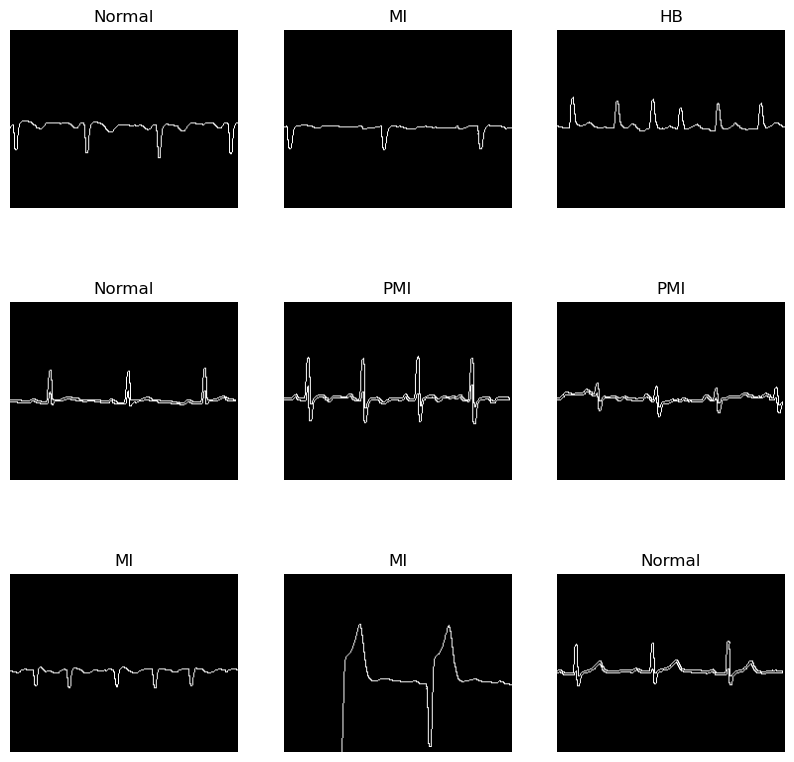

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
list_ds = tf.data.Dataset.list_files(str(data_dir_path/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())

b'../../data/dataset/processed_datasets/ecg_images/Normal/Normal(75)_lead_2.png'
b'../../data/dataset/processed_datasets/ecg_images/Normal/Normal(207)_lead_9.png'
b'../../data/dataset/processed_datasets/ecg_images/HB/HB(229)_lead_6.png'
b'../../data/dataset/processed_datasets/ecg_images/Normal/Normal(90)_lead_10.png'
b'../../data/dataset/processed_datasets/ecg_images/Normal/Normal(72)_lead_8.png'


2024-11-18 16:51:06.002398: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
class_names = np.array(sorted([item.name for item in data_dir_path.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['HB' 'MI' 'Normal' 'PMI']


In [10]:
test_size = int(image_count * 0.2)
train_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)

In [11]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 230, 3)
Label:  0


In [15]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

2024-11-18 16:51:07.697954: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


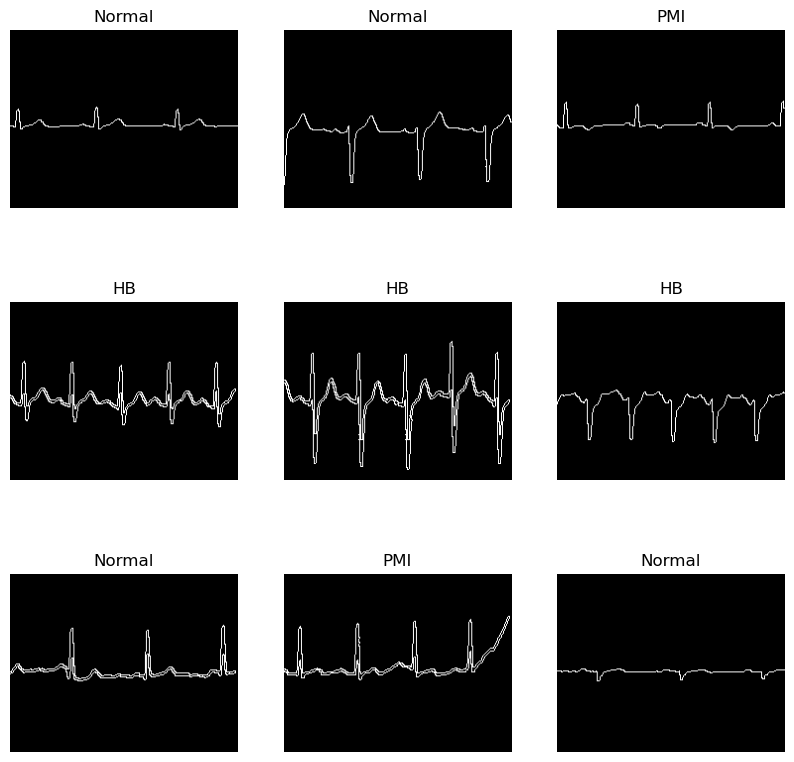

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [17]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

: 

In [ ]:
model.fit(
  train_ds,
  epochs=1
)

 76/179 ━━━━━━━━━━━━━━━━━━━━ 3:21 2s/step - accuracy: 0.4071 - loss: 1.2356